### Note to the TA/Checker

Due to computational and storage constraints, we decided, after discussing with the instructor, to use PubChem's PUG REST API rather than downloading the entire database. This choice was sufficient for our analysis, particularly for the second objective, as retrieving more compounds would have required significantly more resources. To determine the Maximum Common Substructure (MCS), we utilized code from the tutorial provided on 06/11/24, which integrates pubchempy and RDKit to perform this analysis effectively. For the MCS threshold, we opted for 0.9 instead of lower values like 0.8 or 0.7 because the latter made the process excessively time-consuming. By choosing a more restrictive threshold, we balanced precision and efficiency to ensure the script could run within a reasonable timeframe. Additionally, we excluded the top 5 compounds similar to `Coproporphyrinogen III` and the top 2 compounds similar to `3-Deoxy-3-[4-(3-Fluorophenyl)-1H-1,2,3-Triazol-1-Yl]-Beta-D-Galactopyranosyl 3-Deoxy-3-[4-(3-Fluorophenyl)-1H-1,2,3-Triazol-1-Yl]-1-Thio-Beta-D-Galactopyranoside` as these were stereoisomers with a Tanimoto coefficient of 1.0, indicating identical structure.

************************************************************************************************

### Steps followed for Similar Compounds and Maximum Common Substructure (MCS) Analysis of the 2 given molecules (CID 321, 73774610)

#### Part 1: Setup and Retrieval of Similar Compounds

1. **Install Libraries**: We installed `rdkit` and `pubchempy` for handling chemical structures and similarity searches.

2. **Connect to PubChem**: Connected to PubChem's REST API and verified access with a sample compound (CID 321).

3. **Retrieve Similar Compounds**:
   - For each compound CID (321 and 73774610), retrieved the SMILES string and conducted a similarity search with a 90% threshold.
   - Retrieved CIDs of similar compounds, fetching key properties (IUPAC name, molecular weight, SMILES, and InChIKey) for the top 50 matches `from the complete database`.
   - Saved data to `similar_compounds_321.csv` and `similar_compounds_73774610.csv`.

4. **Load and Prepare Data**:
   - Loaded `similar_compounds_321.csv`, selected the first 10 rows, and converted SMILES strings to RDKit molecule objects with IUPAC name properties.
   - Saved these molecule objects to `compounds_data.sdf`.

#### Part 2: Maximum Common Substructure (MCS) Analysis

1. **Load and Display Molecules**:
   - Loaded molecules from `compounds_data.sdf`, extracted IUPAC names, and displayed the first 5 molecules.

2. **Find and Visualize MCS**:
   - Used `rdFMCS.FindMCS` to find the Maximum Common Substructure, displaying the number of atoms, bonds, and SMARTS string.
   - Visualized the MCS structure and highlighted it within the original molecules.

3. **Experiment with MCS Parameters**:
   - Explored different MCS parameters (`threshold` and `ringMatchesRingOnly`, as shown to us the tutorials) and visualized the resulting structures within the molecules.

### Part 3: Repetition for the second compound
- We repeated Part 2 of the analysis for the other compound in similar_compounds_73774610.csv, following the same steps to load, visualize, and analyze the MCS for this new set of similar compounds.

In [48]:
import time
import random
from pathlib import Path

import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator


In [49]:
!pip install rdkit
!pip install pubchempy

In [50]:
import requests

compound_cid = 321  #Just to check whether the connection works or not by fetching basic details

test_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{compound_cid}/property/IUPACName,MolecularWeight,CanonicalSMILES,InChIKey/JSON"
response = requests.get(test_url)

if response.status_code == 200:
    print("Connection successful. Compound data:")
    print(response.json())
else:
    print(f"Error: Status code {response.status_code}. Check connectivity or CID.")


Connection successful. Compound data:
{'PropertyTable': {'Properties': [{'CID': 321, 'MolecularWeight': '660.8', 'CanonicalSMILES': 'CC1=C2CC3=C(C(=C(N3)CC4=C(C(=C(N4)CC5=C(C(=C(N5)CC(=C1CCC(=O)O)N2)C)CCC(=O)O)C)CCC(=O)O)CCC(=O)O)C', 'InChIKey': 'NIUVHXTXUXOFEB-UHFFFAOYSA-N', 'IUPACName': '3-[8,12,17-tris(2-carboxyethyl)-3,7,13,18-tetramethyl-5,10,15,20,21,22,23,24-octahydroporphyrin-2-yl]propanoic acid'}]}}


In [51]:
cid_lst = [321,73774610]

In [52]:
for compound_cid in cid_lst:
  smiles_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{compound_cid}/property/CanonicalSMILES/JSON"
  smiles_response = requests.get(smiles_url)

  if smiles_response.status_code == 200:
      smiles = smiles_response.json()["PropertyTable"]["Properties"][0]["CanonicalSMILES"]
      print(f"SMILES for CID {compound_cid}: {smiles}")

      # Step 2: Use the SMILES in a structure search with asynchronous handling
      structure_search_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{smiles}/JSON?Threshold=90&list_return=listkey"
      structure_response = requests.get(structure_search_url)

      if structure_response.status_code == 202:
          # Query accepted, retrieve listkey for polling
          listkey = structure_response.json()["Waiting"]["ListKey"]
          print("Query accepted. Polling for results...")

          # Step 3: Poll for results using the listkey
          result_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{listkey}/cids/JSON"
          similar_cids = []

          while not similar_cids:
              time.sleep(5)  # Wait 5 seconds between polls to avoid spamming
              result_response = requests.get(result_url)

              if result_response.status_code == 200:
                  similar_cids = result_response.json()["IdentifierList"]["CID"]
              elif result_response.status_code == 202:
                  print("Still processing. Retrying...")
              else:
                  print(f"Error: Status code {result_response.status_code}")
                  break

          # Step 4: Process the results if available
          if similar_cids:
              top_n = 50  #Since the computational complexity was quite high, we have limited n to be 50, to get the top 50 most similar compounds on the basis of tanimoto similarity
              compound_data = []
              for i, cid in enumerate(similar_cids[:top_n]):
                  if i > 0 and i % 5 == 0:
                      time.sleep(1)  #1-second delay every 5 requests, and pausing every 5 seconds because of rate limiting

                  properties_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/IUPACName,MolecularWeight,CanonicalSMILES,InChIKey/JSON"
                  properties_response = requests.get(properties_url)

                  if properties_response.status_code == 200:
                      properties = properties_response.json()["PropertyTable"]["Properties"][0]
                      compound_data.append({
                          "CID": cid,
                          "iupac_name": properties.get("IUPACName"),
                          "Molecular Weight": properties.get("MolecularWeight"),
                          "canonical_smiles": properties.get("CanonicalSMILES"),
                          "InChIKey": properties.get("InChIKey")
                      })
                  else:
                      print(f"Error fetching properties for CID {cid}: {properties_response.status_code}")

              # Step 5: Save the data to a CSV file
              if compound_cid == 321:
                df1 = pd.DataFrame(compound_data)
                # df.to_csv("similar_compounds_321.csv", index=False)
                print("CSV file 'similar_compounds_321.csv' saved successfully.")
              else:
                df2 = pd.DataFrame(compound_data)
                # df.to_csv("similar_compounds_73774610.csv", index=False)
                print("CSV file 'similar_compounds_73774610.csv' saved successfully.")

          else:
              print(f"No similar compounds found.--{compound_cid }")

      else:
          print(f"Error:{compound_cid } {structure_response.status_code}")

  else:
      print(f"Failed to retrieve SMILES for the compound.--{compound_cid}")


SMILES for CID 321: CC1=C2CC3=C(C(=C(N3)CC4=C(C(=C(N4)CC5=C(C(=C(N5)CC(=C1CCC(=O)O)N2)C)CCC(=O)O)C)CCC(=O)O)CCC(=O)O)C
Query accepted. Polling for results...
CSV file 'similar_compounds_321.csv' saved successfully.
SMILES for CID 73774610: C1=CC(=CC(=C1)F)C2=CN(N=N2)C3C(C(OC(C3O)SC4C(C(C(C(O4)CO)O)N5C=C(N=N5)C6=CC(=CC=C6)F)O)CO)O
Query accepted. Polling for results...
CSV file 'similar_compounds_73774610.csv' saved successfully.


In [53]:
# df1 = pd.read_csv('similar_compounds_321.csv')
df1["MolObj"] = df1['canonical_smiles'].map(lambda x: Chem.MolFromSmiles(x))
df2["MolObj"] = df2['canonical_smiles'].map(lambda x: Chem.MolFromSmiles(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
original321_smiles = 'CC1=C2CC3=C(C(=C(N3)CC4=C(C(=C(N4)CC5=C(C(=C(N5)CC(=C1CCC(=O)O)N2)C)CCC(=O)O)C)CCC(=O)O)CCC(=O)O)C'
original321mol = Chem.MolFromSmiles(original321_smiles)
original321fp = Chem.RDKFingerprint(original321mol, maxPath=7, fpSize=512)

original7377_smiles = 'C1=CC(=CC(=C1)F)C2=CN(N=N2)[C@H]3[C@H]([C@H](O[C@H]([C@@H]3O)S[C@H]4[C@@H]([C@H]([C@H]([C@H](O4)CO)O)N5C=C(N=N5)C6=CC(=CC=C6)F)O)CO)O'
original7377mol = Chem.MolFromSmiles(original7377_smiles)
original7377fp = Chem.RDKFingerprint(original7377mol, maxPath=7, fpSize=512)

# Function to calculate fingerprint for each molecule in the DataFrame
def calculate_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.RDKFingerprint(mol, maxPath=7, fpSize=512)
    return None

# Function to calculate Tanimoto similarity between two fingerprints
def calculate_tanimoto(fp, ref_fp):
    if fp is None:
        return None
    return DataStructs.TanimotoSimilarity(fp, ref_fp)

# Create the 'fingerprint' column
df1['fingerprint'] = df1['canonical_smiles'].apply(calculate_fp)
df2['fingerprint'] = df2['canonical_smiles'].apply(calculate_fp)


# Create the 'tanimoto_similarity' column using the reference fingerprint for compound X
df1['tanimoto_similarity'] = df1['fingerprint'].apply(lambda fp: calculate_tanimoto(fp, original321fp))
df2['tanimoto_similarity'] = df2['fingerprint'].apply(lambda fp: calculate_tanimoto(fp, original7377fp))



# Display the updated DataFrame
# df1[['canonical_smiles', 'fingerprint', 'tanimoto_similarity']].head()

df1 = df1.sort_values(by = 'tanimoto_similarity', ascending = False)
df2 = df2.sort_values(by = 'tanimoto_similarity', ascending = False)

In [68]:
df1 = df1.iloc[6::, :: ]

In [69]:
df2 = df2.iloc[3:: , ::]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 23 to 9
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CID                  47 non-null     int64  
 1   iupac_name           47 non-null     object 
 2   Molecular Weight     47 non-null     object 
 3   canonical_smiles     47 non-null     object 
 4   InChIKey             47 non-null     object 
 5   MolObj               47 non-null     object 
 6   fingerprint          47 non-null     object 
 7   tanimoto_similarity  47 non-null     float64
dtypes: float64(1), int64(1), object(6)
memory usage: 3.3+ KB


In [71]:
df1.to_csv('similar_compounds_321.csv', index=False)
df2.to_csv('similar_compounds_73774610.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **MCS**

Import Necessary Libraries

In [72]:
import time
import random
from pathlib import Path

import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator


In [73]:
# Load the CSV file
csv_file = 'similar_compounds_321.csv'
df = pd.read_csv(csv_file)

df = df.iloc[:10:, ::]

# Ensure that the IUPAC names are treated as strings and strip any leading/trailing whitespace
df['iupac_name'] = df['iupac_name'].astype(str).str.strip()


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CID                  10 non-null     int64  
 1   iupac_name           10 non-null     object 
 2   Molecular Weight     10 non-null     float64
 3   canonical_smiles     10 non-null     object 
 4   InChIKey             10 non-null     object 
 5   MolObj               10 non-null     object 
 6   fingerprint          10 non-null     object 
 7   tanimoto_similarity  10 non-null     float64
dtypes: float64(2), int64(1), object(5)
memory usage: 768.0+ bytes


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
# Create an empty list to hold RDKit molecule objects
mols = []

# Convert SMILES to RDKit molecule objects
for index, row in df.iterrows():
    smiles = row['canonical_smiles']
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Assign the IUPAC name as a property
        mol.SetProp('IUPAC_Name', row['iupac_name'])
        mols.append(mol)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
mols

Write Molecules to an SDF File

In [77]:
from rdkit import Chem

# Assuming 'mols' is a list of RDKit molecule objects
output_sdf = 'compounds_data.sdf'
with Chem.SDWriter(output_sdf) as writer:
    for mol in mols:
        writer.write(mol)

print(f"Set with {len(mols)} molecules written to {output_sdf}.")


Set with 10 molecules written to compounds_data.sdf.


Load Molecules from SDF and Draw Them

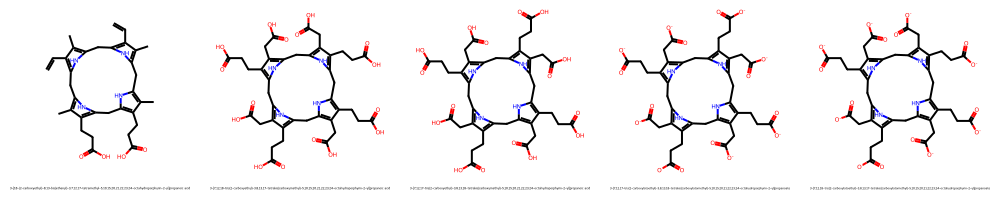

In [78]:
# Load SDF file
suppl = Chem.SDMolSupplier('/content/compounds_data.sdf')
mols = [mol for mol in suppl if mol is not None]  # Filter out None values

# Extract names from the IUPAC_Name property
legends = [mol.GetProp("IUPAC_Name") if mol.HasProp("IUPAC_Name") else "" for mol in mols]

# Show only the first `num_mols` molecules
num_mols = 5
img = Draw.MolsToGridImage(mols[:num_mols], legends=legends[:num_mols], molsPerRow=5)
img  # Use appropriate method to display or save the image


Find the Maximum Common Substructure (MCS)

In [79]:
from rdkit.Chem import rdFMCS

In [80]:
mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)


MCS1 contains 37 atoms and 36 bonds.
MCS SMARTS string: [#6]-,:[#6](:[#6](-,:[#6]-,:[#6](:,-[#6](:,-[#6](:,-[#6]-,:[#6])-[#6])-[#6]):,-[#7]):[#7]:[#6]-,:[#6]-,:[#6](:,-[#6]-[#6]-[#6]-[#6](=[#8])-[#8]):[#7]:[#6](-,:[#6]-,:[#6](:,-[#6]-[#6]):,-[#7]:,-[#6]:,-[#6]-[#6]):,-[#6]-[#6]):,-[#6]-[#6]-[#6]


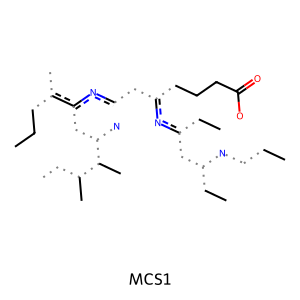

In [81]:
# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

Highlight the MCS in the Molecules

In [82]:
from copy import deepcopy
from rdkit import Geometry
from rdkit.Chem import AllChem

def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # Convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # Find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label:
        legends = []
        for mol in molecules:
            try:
                legends.append(mol.GetProp("_Name"))
            except KeyError:
                legends.append("")  # Or any default name you'd like to use

    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )



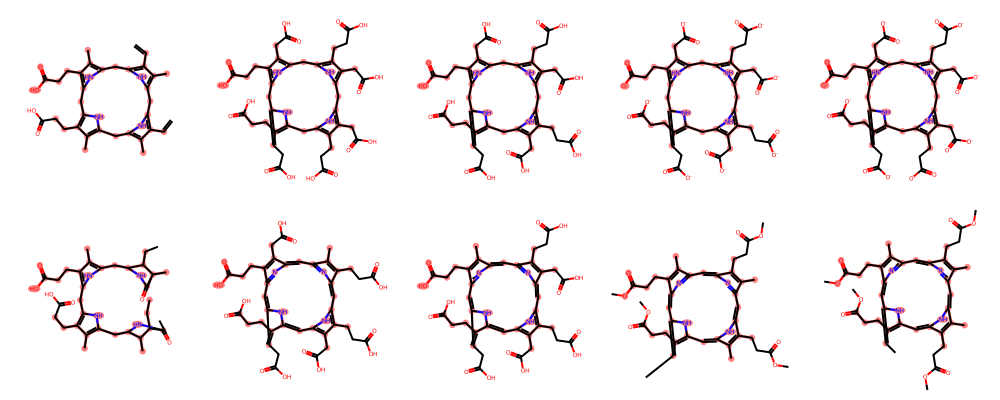

In [83]:
highlight_molecules(mols, mcs1, 10)

In [84]:
mols

In [85]:
#Find MCS with Different Parameters
mcs2 = rdFMCS.FindMCS(mols, threshold=0.9)
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("SMARTS string:", mcs2.smartsString)


MCS2 contains 37 atoms and 38 bonds.
SMARTS string: [#6]-[#6]1:[#6]2-,:[#6]-,:[#6](:,-[#6]-[#6]):[#7]:[#6](:,-[#6]-[#6])-,:[#6]-,:[#6](:,-[#6]-[#6]):[#7]:[#6](-,:[#6]-,:[#6]:[#7]:[#6](-,:[#6]-,:[#6](:[#6]:1-[#6]-[#6]-[#6](=[#8])-[#8]):[#7]:2):[#6](:,-[#6])-,:[#6]-[#6]-[#6]):,-[#6]-[#6]


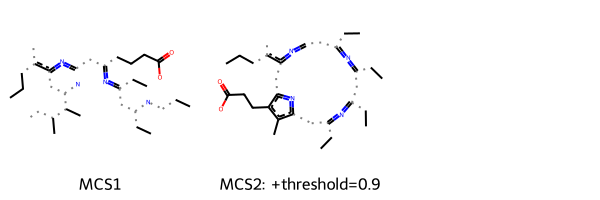

In [86]:
# Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.9"])

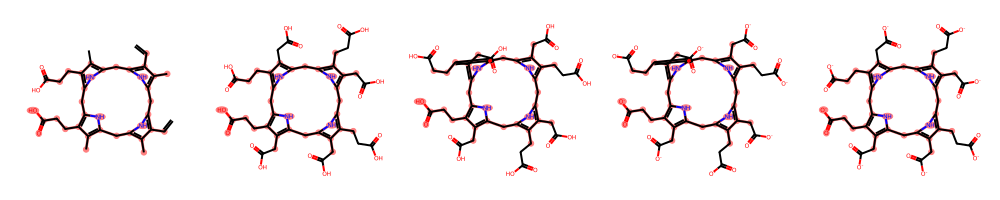

In [87]:
highlight_molecules(mols, mcs2, 5)

Visualize MCS with Different Thresholds

In [88]:
mcs3 = rdFMCS.FindMCS(mols, threshold=0.9, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)


MCS3 contains 36 atoms and 38 bonds.
SMARTS string: [#6&!R]-&!@[#6]1:&@[#6]2-,:;@[#6]-,:;@[#6](:,-;@[#6&R]-&!@[#6&!R]):&@[#7]:&@[#6](:,-;@[#6&R]-&!@[#6&!R])-,:;@[#6]-,:;@[#6](:,-;@[#6&R]-&!@[#6&!R]):&@[#7]:&@[#6](-,:;@[#6]-,:;@[#6]3:&@[#7]:&@[#6](-,:;@[#6]-,:;@[#6](:&@[#6]:&@1-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R]):&@[#7]:&@2):&@[#6](:&@[#6]:&@3-&!@[#6&!R])-&!@[#6&!R]):,-;@[#6&R]-&!@[#6&!R]


MCS3 contains 36 atoms and 38 bonds.
SMARTS string: [#6&!R]-&!@[#6]1:&@[#6]2-,:;@[#6]-,:;@[#6](:,-;@[#6&R]-&!@[#6&!R]):&@[#7]:&@[#6](:,-;@[#6&R]-&!@[#6&!R])-,:;@[#6]-,:;@[#6](:,-;@[#6&R]-&!@[#6&!R]):&@[#7]:&@[#6](-,:;@[#6]-,:;@[#6]3:&@[#7]:&@[#6](-,:;@[#6]-,:;@[#6](:&@[#6]:&@1-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R]):&@[#7]:&@2):&@[#6](:&@[#6]:&@3-&!@[#6&!R])-&!@[#6&!R]):,-;@[#6&R]-&!@[#6&!R]


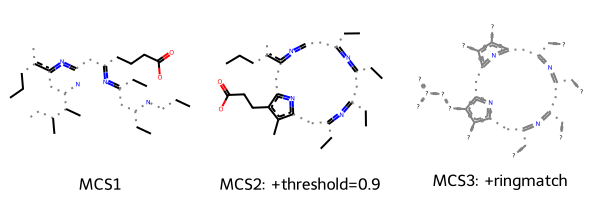

In [89]:
m3 = rdFMCS.FindMCS(mols, threshold=0.9, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)

# Draw substructures
m1 = Chem.MolFromSmarts(mcs1.smartsString)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
m3 = Chem.MolFromSmarts(mcs3.smartsString)

Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +threshold=0.9", "MCS3: +ringmatch"])


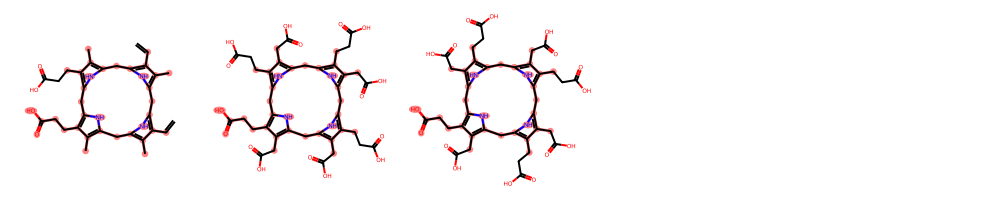

In [90]:
highlight_molecules(mols, mcs3, 3)

In [91]:
# Load the CSV file
csv_file = 'similar_compounds_73774610.csv'
df = pd.read_csv(csv_file)

df = df.iloc[:10: , ::]

# Ensure that the IUPAC names are treated as strings and strip any leading/trailing whitespace
df['iupac_name'] = df['iupac_name'].astype(str).str.strip()


In [92]:
# Create an empty list to hold RDKit molecule objects
mols = []

# Convert SMILES to RDKit molecule objects
for index, row in df.iterrows():
    smiles = row['canonical_smiles']
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Assign the IUPAC name as a property
        mol.SetProp('IUPAC_Name', row['iupac_name'])
        mols.append(mol)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Write Molecules to an SDF File

In [93]:
from rdkit import Chem

# Assuming 'mols' is a list of RDKit molecule objects
output_sdf = 'compounds_data2.sdf'
with Chem.SDWriter(output_sdf) as writer:
    for mol in mols:
        writer.write(mol)

print(f"Set with {len(mols)} molecules written to {output_sdf}.")


Set with 10 molecules written to compounds_data2.sdf.


Load Molecules from SDF and Draw Them

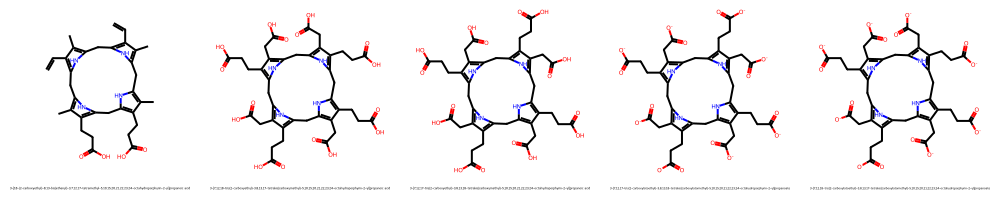

In [94]:
# Load SDF file
suppl = Chem.SDMolSupplier('/content/compounds_data.sdf')
mols = [mol for mol in suppl if mol is not None]  # Filter out None values

# Extract names from the IUPAC_Name property
legends = [mol.GetProp("IUPAC_Name") if mol.HasProp("IUPAC_Name") else "" for mol in mols]

# Show only the first `num_mols` molecules
num_mols = 5
img = Draw.MolsToGridImage(mols[:num_mols], legends=legends[:num_mols], molsPerRow=5)
img  # Use appropriate method to display or save the image


Find the Maximum Common Substructure (MCS)

In [95]:
from rdkit.Chem import rdFMCS

mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)


MCS1 contains 37 atoms and 36 bonds.
MCS SMARTS string: [#6]-,:[#6](:[#6](-,:[#6]-,:[#6](:,-[#6](:,-[#6](:,-[#6]-,:[#6])-[#6])-[#6]):,-[#7]):[#7]:[#6]-,:[#6]-,:[#6](:,-[#6]-[#6]-[#6]-[#6](=[#8])-[#8]):[#7]:[#6](-,:[#6]-,:[#6](:,-[#6]-[#6]):,-[#7]:,-[#6]:,-[#6]-[#6]):,-[#6]-[#6]):,-[#6]-[#6]-[#6]


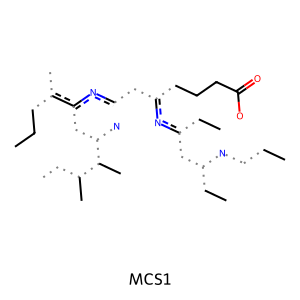

In [96]:
# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

Highlight the MCS in the Molecules

In [97]:
from copy import deepcopy
from rdkit import Geometry
from rdkit.Chem import AllChem

def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # Convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # Find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label:
        legends = []
        for mol in molecules:
            try:
                legends.append(mol.GetProp("_Name"))
            except KeyError:
                legends.append("")  # Or any default name you'd like to use

    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )



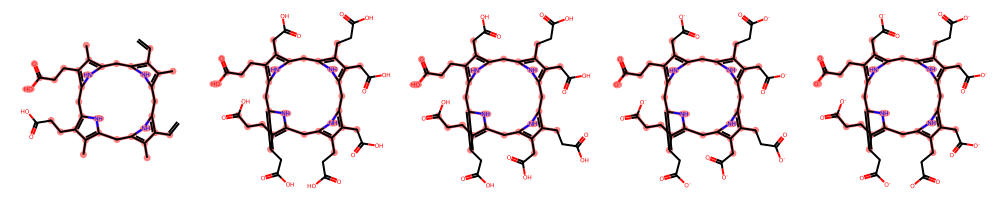

In [98]:

highlight_molecules(mols, mcs1, 5)

In [99]:
#Find MCS with Different Parameters
mcs2 = rdFMCS.FindMCS(mols, threshold=0.9)
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("SMARTS string:", mcs2.smartsString)


MCS2 contains 37 atoms and 38 bonds.
SMARTS string: [#6]-[#6]1:[#6]2-,:[#6]-,:[#6](:,-[#6]-[#6]):[#7]:[#6](:,-[#6]-[#6])-,:[#6]-,:[#6](:,-[#6]-[#6]):[#7]:[#6](-,:[#6]-,:[#6]:[#7]:[#6](-,:[#6]-,:[#6](:[#6]:1-[#6]-[#6]-[#6](=[#8])-[#8]):[#7]:2):[#6](:,-[#6])-,:[#6]-[#6]-[#6]):,-[#6]-[#6]


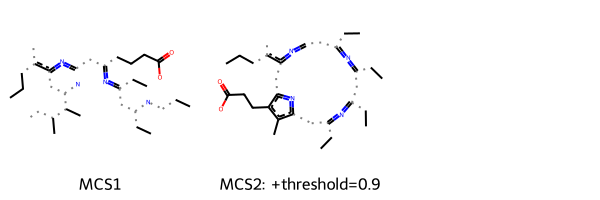

In [100]:
# Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.9"])

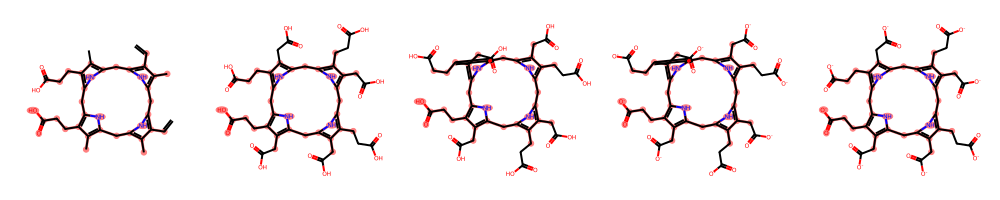

In [101]:
highlight_molecules(mols, mcs2, 5)

Visualize MCS with Different Thresholds

In [102]:
mcs3 = rdFMCS.FindMCS(mols, threshold=0.9, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)


MCS3 contains 36 atoms and 38 bonds.
SMARTS string: [#6&!R]-&!@[#6]1:&@[#6]2-,:;@[#6]-,:;@[#6](:,-;@[#6&R]-&!@[#6&!R]):&@[#7]:&@[#6](:,-;@[#6&R]-&!@[#6&!R])-,:;@[#6]-,:;@[#6](:,-;@[#6&R]-&!@[#6&!R]):&@[#7]:&@[#6](-,:;@[#6]-,:;@[#6]3:&@[#7]:&@[#6](-,:;@[#6]-,:;@[#6](:&@[#6]:&@1-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R]):&@[#7]:&@2):&@[#6](:&@[#6]:&@3-&!@[#6&!R])-&!@[#6&!R]):,-;@[#6&R]-&!@[#6&!R]


MCS3 contains 36 atoms and 38 bonds.
SMARTS string: [#6&!R]-&!@[#6]1:&@[#6]2-,:;@[#6]-,:;@[#6](:,-;@[#6&R]-&!@[#6&!R]):&@[#7]:&@[#6](:,-;@[#6&R]-&!@[#6&!R])-,:;@[#6]-,:;@[#6](:,-;@[#6&R]-&!@[#6&!R]):&@[#7]:&@[#6](-,:;@[#6]-,:;@[#6]3:&@[#7]:&@[#6](-,:;@[#6]-,:;@[#6](:&@[#6]:&@1-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R]):&@[#7]:&@2):&@[#6](:&@[#6]:&@3-&!@[#6&!R])-&!@[#6&!R]):,-;@[#6&R]-&!@[#6&!R]


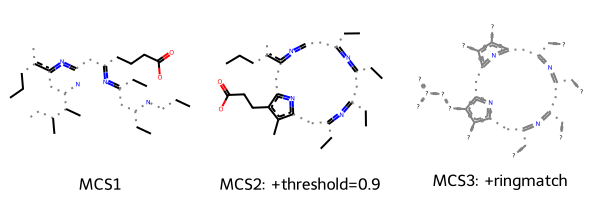

In [103]:
m3 = rdFMCS.FindMCS(mols, threshold=0.9, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)

# Draw substructures
m1 = Chem.MolFromSmarts(mcs1.smartsString)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
m3 = Chem.MolFromSmarts(mcs3.smartsString)

Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +threshold=0.9", "MCS3: +ringmatch"])


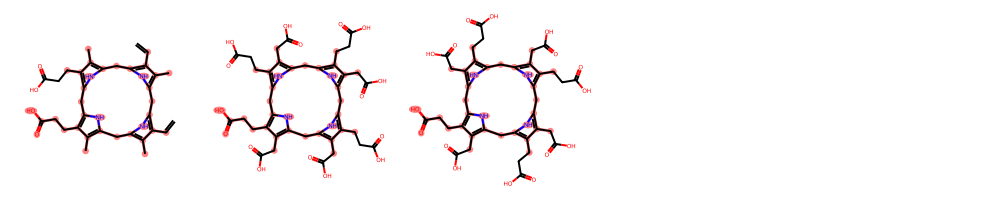

In [104]:
highlight_molecules(mols, mcs3, 3)